<img src="../code/Resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 2: Tutorial on neuronal encoding and behavior</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 26th, 2025</h3> 
<h4 align="center">Day 2</h4> 

In [4]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd
import pynwb

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

pd.set_option('display.max_columns', None)

%matplotlib inline

In [5]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

In [23]:
session_id = '742903_2024-10-22'

nwb_path = f'/root/capsule/data/{session_id}.nwb'
session = pynwb.NWBHDF5IO(nwb_path).read()

trials = session.trials.to_dataframe()

trial_start = trials.start_time.values
trial_stop = trials.stop_time.values

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [34]:
# face expressions, running, pupil

# running
running_data = session.processing['behavior']['running_speed']
running_timestamps = running_data.timestamps[:]
running_speed = running_data.data[:]
mean_speed = [np.nanmean(running_speed[np.logical_and(s1 <= running_timestamps, running_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# pupil
pupil_data = session.processing['behavior']['eye_tracking']
pupil_timestamps = pupil_data.timestamps[:]
pupil_area = pupil_data.pupil_area[:]
mean_pupil_area = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_timestamps, pupil_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# lick counts
lick_data = session.processing['behavior']['licks']
lick_times = lick_data.timestamps[:]
lick_duration = lick_data.data[:]
lick_duration_threshold = 0.5
lick_times = lick_times[lick_duration < lick_duration_threshold]
in_bin = (lick_times[:, None] >= trial_start) & (lick_times[:, None] < trial_stop)
lick_counts = np.any(in_bin, axis=0).astype(int)

behavior_data = pd.DataFrame({
    'mean_speed': mean_speed, 
    'mean_pupil_area': mean_pupil_area, 
    'lick_counts': lick_counts,
})

# response rates
vis1_response_rate = trials[(trials["stim_name"] == 'vis1') & (trials.is_go)].is_hit.rolling(10).mean()
vis2_response_rate = trials[(trials["stim_name"] == 'vis2') & (trials.is_go)].is_hit.rolling(10).mean()
sound1_response_rate = trials[(trials["stim_name"] == 'sound1') & (trials.is_go)].is_hit.rolling(10).mean()
sound2_response_rate = trials[(trials["stim_name"] == 'sound2') & (trials.is_go)].is_hit.rolling(10).mean()

task_data = pd.DataFrame({
    'vis1_reponse_rate': vis1_response_rate, 
    'vis2_reponse_rate': vis2_response_rate,
    'sound1_reponse_rate': sound1_response_rate,
    'sound2_reponse_rate': sound2_response_rate,
})

In [38]:
from sklearn.preprocessing import StandardScaler
# Extract data for running state analysis
data = behavior_data[['lick_counts', 'mean_speed', 'mean_pupil_area']].values
data[np.isnan(data)] = 0

# For this model, it's important that the data is converted into a *JAX* array
observations = jnp.array(data)

# First scale the dimensions of the data to be normalized
scaler = StandardScaler()      
observations = scaler.fit_transform(observations)

# Split the data into equal length batches for cross-validation
n_batches = 6
n_steps = data.shape[0] - (data.shape[0] % n_batches)
batched_observations = observations[:n_steps, :].reshape(n_batches, -1, observations.shape[1])
batch_size = batched_observations.shape[1]

In [39]:
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation

# Define empty lists that we'll populate below
avg_test_log_probs = []
all_test_log_probs = []
std_test_log_probs = []
similarity_of_states_across_batches = []
#lp_all = []
#numstates_all = []
#test_lp_all= []
key = jr.PRNGKey(0)

# Run a loop to fit the data to a range of states
for num_states in range(1, 8):
    print("num states: ", num_states)

    test_log_probs = []
    predicted_states = np.zeros([observations.shape[0], n_batches], dtype = int)
    
    for batch in trange(n_batches):
        # Extract all but this batch for training
        train_observations = np.concatenate([batched_observations[:batch], batched_observations[batch+1:]])#.reshape((n_batches - 1)*batch_size, -1)
        flat_train_observations = train_observations.reshape((n_batches - 1) * batch_size, -1)
        
        if num_states == 1:
            print('fitting a single Gaussian')
            train_mean = jnp.mean(flat_train_observations, axis=0).reshape([1,3])
            train_cov = jnp.cov(flat_train_observations.T)
            test_data = jnp.array(batched_observations[batch])#scaler.transform(jnp.array(batched_observations[batch]))
            test_lp = tfd.MultivariateNormalFullCovariance(train_mean, train_cov).log_prob(batched_observations[batch]).sum()
        else:
            # Make an HMM
            hmm = GaussianHMM(num_states, batched_observations.shape[2])
            params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_observations))

            # Fit the model
            params, lps = hmm.fit_em(params, param_props, jnp.array(train_observations), num_iters=500)
            
            #extract predicted states
            predicted_states[:,batch] = hmm.most_likely_states(params, observations)

            # Evaluate the log probability on held out data
            test_lp = hmm.marginal_log_prob(params, jnp.array(batched_observations[batch]))
        test_log_probs.append(test_lp)
        #lp_all.append(test_lp)
        #numstates_all.append(num_states)
    
    # Calculate the similarity of each set of predicted states
    if batch != 1:
        distance_between_batches = []
        for i in range(n_batches):
            for j in range(i-1):
                bestpermutation = find_permutation(predicted_states[:,i], predicted_states[:,j])
                distance_between_batches.append(np.sum(jnp.take(bestpermutation, predicted_states[:,i]) == predicted_states[:,j])/observations.shape[0])
        similarity_of_states_across_batches.append(np.mean(distance_between_batches))
    else:
        similarity_of_states_across_batches.append(1)
        
    # Store the average test log prob
    all_test_log_probs.append(test_log_probs)
    avg_test_log_probs.append(np.nanmean(test_log_probs))
    std_test_log_probs.append(np.nanstd(test_log_probs))    

num states:  1


  0%|          | 0/6 [00:00<?, ?it/s]

fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
num states:  2


  0%|          | 0/6 [00:00<?, ?it/s]

num states:  3


  0%|          | 0/6 [00:00<?, ?it/s]

num states:  4


  0%|          | 0/6 [00:00<?, ?it/s]

num states:  5


  0%|          | 0/6 [00:00<?, ?it/s]

num states:  6


  0%|          | 0/6 [00:00<?, ?it/s]

num states:  7


  0%|          | 0/6 [00:00<?, ?it/s]

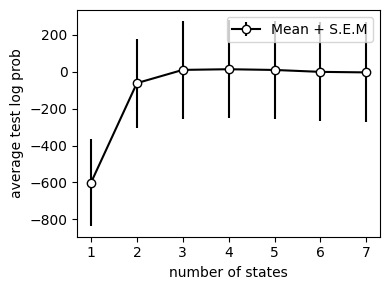

In [42]:
plt.figure(figsize = (4, 3))
plt.errorbar(np.arange(1, 8), avg_test_log_probs, yerr = np.array(std_test_log_probs)/np.sqrt(n_batches), mfc = 'w', color = 'k', marker = 'o')

# If you like, you can plot up each of the log_probs from the session.
#for k, test_log_probs in zip(np.arange(1, 8), all_test_log_probs):
#    plt.plot(k * np.ones(n_batches), test_log_probs, 'r.')

plt.legend(['Mean + S.E.M'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

In [57]:
best_num_states = 3

In [58]:
key = jr.PRNGKey(0)

number_of_states = best_num_states

input_data = behavior_data[['lick_counts', 'mean_speed', 'mean_pupil_area']].values

final_hmm = GaussianHMM(number_of_states, input_data.shape[1], transition_matrix_stickiness=10.)

params, props = final_hmm.initialize(key=key, method="kmeans", emissions=input_data)

params, lps = final_hmm.fit_em(params, props, input_data, num_iters=500)

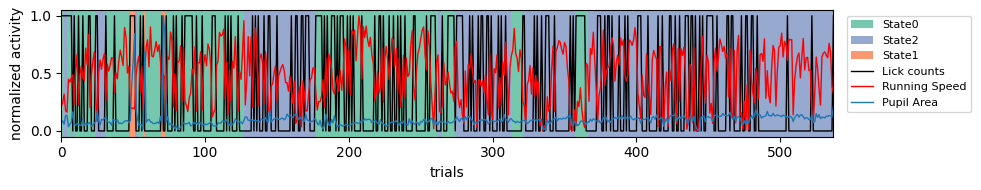

In [59]:
go_trials = np.arange(len(trials))

def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 

# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, input_data)

# Overlay the precision and recall curves on top of the inferred states
fig, ax = plt.subplots(figsize=(10, 2))
cmap =sns.color_palette("Set2", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

# Define state boundaries 
states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))

# Plot the states 
for i, trial in enumerate(switch_trials[:-1]):
    for state_no in range(best_num_states):
        if states[trial+1] == state_no: 
            ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], 
                       facecolor= cmap[state_no], alpha=0.9, label = 'State' + str(state_no))

# Overlay behavioral variables 

plt.plot(go_trials, minmax(lick_counts), '-k', label="Lick counts", lw = 1 )
plt.plot(go_trials, minmax(mean_speed), color = 'r', label="Running Speed", lw = 1)
plt.plot(go_trials, minmax(mean_pupil_area), color = 'tab:blue', label="Pupil Area", lw = 1)


# Formatting 
plt.xlim(go_trials[0], go_trials[-1])
plt.ylabel("normalized activity")
plt.xlabel("trials")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1), fontsize = 8)
plt.tight_layout()